# 概述
&emsp;&emsp;本项目主要基于Python+Tensorflow 2.1 实现faster rcnn算法进行目标检测，模型由一张RTX2070显卡进行训练。



## VOC数据集

[VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#data)数据集主要用于现实场景的多对象识别，该数据集提供了含20个对象的图像训练集：

- *Person:* person
- *Animal:* bird, cat, cow, dog, horse, sheep
- *Vehicle:* aeroplane, bicycle, boat, bus, car, motorbike, train
- *Indoor:* bottle, chair, dining table, potted plant, sofa, tv/monitor

---

&emsp;&emsp;在官网下载数据集解压后的文件目录如下：

![解压后的目录](https://tva1.sinaimg.cn/large/007S8ZIlly1gf0gspnuz7j30bi03ymys.jpg)

&emsp;&emsp;对于本项目，由于只需进行目标检测，只需用到Annotations、ImageSets、JPEGImages这三个目录下的数据。下面进行详细说明：

### Annotations

&emsp;&emsp;存放相关标注信息，每一张图片对应一个xml文件，具体xml内容如下:

```xml
<annotation>
  <folder>VOC2012</folder>
  <filename>2007_000033.jpg</filename>
  <source>
    <database>The VOC2007 Database</database>
    <annotation>PASCAL VOC2007</annotation>
    <image>flickr</image>
  </source>
  <size>
    <width>500</width>
    <height>366</height>
    <depth>3</depth>
  </size>
  <segmented>1</segmented>
  <object>
    <name>aeroplane</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>9</xmin>
      <ymin>107</ymin>
      <xmax>499</xmax>
      <ymax>263</ymax>
    </bndbox>
  </object>
  <object>
    <name>aeroplane</name>
    <pose>Left</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>421</xmin>
      <ymin>200</ymin>
      <xmax>482</xmax>
      <ymax>226</ymax>
    </bndbox>
  </object>
</annotation>
```

&emsp;&emsp;可以看到，里面保存图片的基本信息和标注信息。

### ImageSets

&emsp;&emsp;本项目只会用到ImageSets/Main下train.txt , val.txt, test.txt这三个文件，里面存储对应训练集，验证集，测试集的图片名称。

###  JPEGImages

&emsp;&emsp;存储所有的图片数据

---

&emsp;&emsp;为了便于后续计算，需要先将VOC数据集解析为如下格式：

![](https://tva1.sinaimg.cn/large/007S8ZIlly1gf0h5p72yzj311a09itkd.jpg)

后续的数据处理和算法请参考代码，代码中有具体的说明。


# 数据处理

In [34]:
import os
from xml.etree import ElementTree as ET
from tqdm.notebook import tqdm
import pprint

## 解析数据集

In [60]:
def get_data(input_path):
    
    """将下载好的数据集解析成指定格式
    Args:
        input_path:本地的VOC数据集存放目录
        
    Returns:
        image_data:list列表，解析后的数据集
        classes_count:字典，key为对应类别名称，value为类别所对应的样本（标注框）个数
        classes_mapping:字典，key为对应类别名称，value为对应类别的一个标识index
    """
    image_data = []
    classes_count = {}
    classes_mapping = {}
    
    data_paths = os.path.join(input_path,"VOC2012")
    # 数据标注目录
    annotations_path = os.path.join(data_paths,"Annotations")
    # 图片目录
    imgsets_path = os.path.join(data_paths,"JPEGImages")
    
    imgsets_path_train = os.path.join(data_paths, 'ImageSets', 'Main', 'train.txt')
    imgsets_path_val = os.path.join(data_paths, 'ImageSets', 'Main', 'val.txt')
    imgsets_path_test = os.path.join(data_paths, 'ImageSets', 'Main', 'test.txt')
    
    train,val,test = [],[],[]
    
    with open(imgsets_path_train) as imgs:
        for img in imgs:
            train.append(img.strip()+'.jpg')
            
    with open(imgsets_path_val) as imgs:
        for img in imgs:
            val.append(img.strip()+'.jpg')
    # PASCAL VOC 2012不包含测试集    
    if os.path.isfile(imgsets_path_test):
        with open(imgsets_path_test) as imgs:
            for img in imgs:
                test.append(line.strip() + '.jpg')
    # 获得所有的标注文件路径，保存到annota_path_list列表中
    annotations_path_list = [os.path.join(annotations_path, p) for p in os.listdir(annotations_path)]
    annotations_path_list = tqdm(annotations_path_list)
    index = 0
    for annotations_path in annotations_path_list:
        exist_flag = False
        index += 1
        annotations_path_list.set_description("Processing %s" % annotations_path.split(os.sep)[-1])

        # 开始解析对应xml数据标注文件
        et = ElementTree.parse(annotations_path)
        element = et.getroot()
        element_objs = element.findall("object")  # 获取所有的object子元素
        element_filename = element.find("filename").text  # 对应图片名称
        element_width = int(element.find("size").find("width").text)  # 对应图片尺寸
        element_height = int(element.find("size").find("height").text)  # 对应图片尺寸
        
        if len(element_objs) > 0:
            annotation_data = {"filepath": os.path.join(imgsets_path, element_filename),
                               "width": element_width,
                               "height": element_height,
                               "image_id": index,
                               "bboxes": []}  # bboxes 用来存放对应标注框的相关位置
        if element_filename in train:
            annotation_data["imageset"] = "train"
            exist_flag = True
        if element_filename in val:
            annotation_data["imageset"] = "val"
            exist_flag = True
        if len(test) > 0:
            if element_filename in test:
                annotation_data["imageset"] = "test"
                exist_flag = True

        if not exist_flag:
            continue

        for element_obj in element_objs:  # 遍历一个xml标注文件中的所有标注框
            classes_name = element_obj.find("name").text  # 获取当前标注框的类别名称
            if classes_name in classes_count:  # classes_count 存储类别以及对应类别的标注框个数
                classes_count[classes_name] += 1
            else:
                classes_count[classes_name] = 1

            if classes_name not in classes_mapping:
                classes_mapping[classes_name] = len(classes_mapping)

            obj_bbox = element_obj.find("bndbox")
            x1 = int(round(float(obj_bbox.find("xmin").text)))
            y1 = int(round(float(obj_bbox.find("ymin").text)))
            x2 = int(round(float(obj_bbox.find("xmax").text)))
            y2 = int(round(float(obj_bbox.find("ymax").text)))

            difficulty = int(element_obj.find("difficult").text) == 1
            annotation_data["bboxes"].append({"class": classes_name,
                                              "x1": x1, "x2": x2, "y1": y1, "y2": y2,
                                              "difficult": difficulty})
        image_data.append(annotation_data)

    return image_data, classes_count, classes_mapping



In [61]:
data_path = '/home/wcjb/Code/Dataset/VOCdevkit'
img_data,cc,cm = get_data(data_path)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 样本示例

&emsp;&emsp;为了对数据集有细致了解，我们取其中一个样本来进行详细说明:可以看到，解析好的数据集字典中包含图片的路径，分辨率，还有标注框的坐标及所属数据集。

In [55]:
img_data[0]

{'filepath': '/home/wcjb/Code/Dataset/VOCdevkit/VOC2012/JPEGImages/2011_001656.jpg',
 'width': 376,
 'height': 500,
 'image_id': 3,
 'bboxes': [{'class': 'horse',
   'x1': 1,
   'x2': 234,
   'y1': 119,
   'y2': 479,
   'difficult': False}],
 'imageset': 'train'}

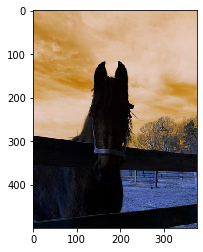

In [83]:
import cv2 
from matplotlib import pyplot as plt
img = cv2.imread('/home/wcjb/Code/Dataset/VOCdevkit/VOC2012/JPEGImages/2011_001656.jpg')
# 由于使用cv2的rectangle函数在图片上绘制标注框时，
# 会默认在原图上进行操作，故需提前创建副本
imgs = img.copy()
plt.imshow(img)

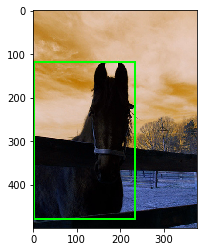

In [84]:
# 根据坐标绘制标注框
cv2.rectangle(imgs, (1,119), (234,479), (0,255,0), 4)
plt.imshow(imgs)

# 数据增强